# Introduction

In [150]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools # for ADF test and coint function
import statsmodels.api # for OLS

# from scipy.stats import norm  # to fit normal dist to data
# import matplotlib.mlab as mlab  # to generate pdfs

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

This report summarises and demonstrates some of the techniques used at arriving at trading strategies using the concepts of _stationarity_ and _cointegration_. In particular, the focus is on energy commodities.

* Section 1 provides details for the datasets used throughout the report
* Section 2 introduces the concept of Stationarity in time series, which  is the key property exploited by cointegration techniques and mean-reverting strategies
* Section 3 goes in detail about Cointegration and how to test for it, as well as assesing its significance
* Section 4 is then dedicated to the application of these concepts to trading strategies and assesing their performance in terms of profit and loss
* Finally the Appendix summarises some of the mathematical methods involved such as Multivariate Regression models (VAR(p), ECM, Augmented Dickey-Fuller Test and Ornstein–Uhlenbeck processes

# Datasets

## Simulated Data

Unless otherwise stated, stochastic processes are simulated with Monte Carlo (MC) where random samples are drawn from the normal distribution.

## Real Data

* For simplicity, only two finacial series are used to demonstrate the concepts. As the focus is on energy commodities, Brent crude and a byproduct (Low Sulphur Gasoil) were selected since they were assumed to be good candidates for cointegration given they are exposed to similar market factors
* The [Brent](https://www.theice.com/products/219/Brent-Crude-Futures) and [Gasoil](https://www.theice.com/products/34361119/Low-Sulphur-Gasoil-Futures) Futures prices traded in the Intercontinental Exchange (ICE) were taken from  [Quandl's Steven Continuous Series](https://www.quandl.com/data/SCF/documentation/about) using the 'Roll on Last Trading Day with No Price Adjustment' version and the 'Settle' field
* The two series were joined to produce a single dataset consisting of daily settlement prices for Brent and Gasoil
* The dataset spans 1.5 'trading years'. The period selected was Jan-2014 to Dec-2014  for the in-sample testing and Jan-2015 to Jun-2015 for the out-of-sample testing. This was because several sources recommend to use one year of historic data to estimate the cointegration parameters and trade the estimates for a 6-month period, given that the parameters might change over time or the relationship cease to exist
* Dates with missing values after joining the two series were dropped
* Since Gasoil is traded in metric tons and Brent in barrels, the gasoil series was divided by 7.45, which is the [ICE conversion factor](https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf)

The figure below shows the resulting dataset (spanning both in-sample and out-of-sample periods), where the two series indeed seem to be closely related, having parallel up and down trends.

             brent      gasoil
Date                          
2014-01-02  107.78  123.959732
2014-01-03  106.89  122.181208
2014-01-06  106.73  122.181208
2014-01-07  107.35  122.214765
2014-01-08  107.15  122.449664
            brent     gasoil
Date                        
2015-06-24  63.49  77.986577
2015-06-25  63.20  76.543624
2015-06-26  63.26  77.046980
2015-06-29  62.01  75.771812
2015-06-30  63.59  77.013423


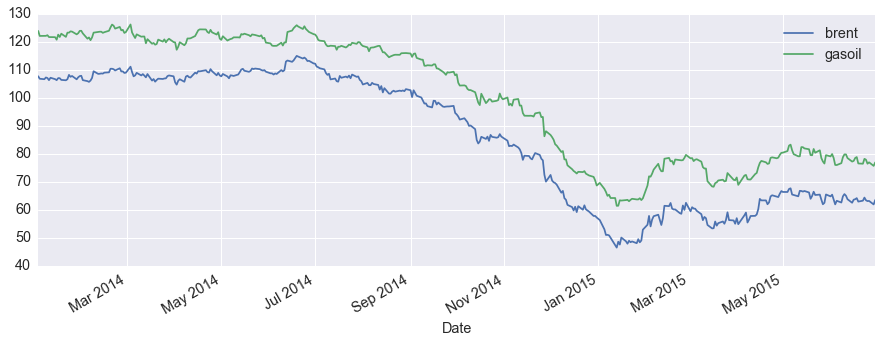

In [182]:
temp = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
df = temp[datetime(2014, 1, 1):datetime(2015, 6, 30)]
print df.head()
print df.tail()
_ = df.plot()

# Stationarity and Mean-Reversion

Before cointegration is introduced, it is important to understand the concept of stationarity. A time series is stationary when the parameters of its generating process do not change over time. In particular, its long-run mean and variance stay constant. This property is fundamental when applying linear regression and forecasting models.

Often, processes with a drift or trend, like stock prices, are non-stationary but can be transformed to become stationary. For example, by differencing prices we get returns, which are in general stationary.

The figure below shows how a simulated random walk with drift $Y_t = \alpha + Y_{t-1} + \epsilon_t$ can be made stationary by differencing $Y_t - Y_{t-1} = \alpha + \epsilon_t$

In [4]:
np.random.seed(1000)  # set the seed
M = 1000  # no. of time steps
Y_t = np.zeros((M + 1))
Y_t[0] = 0.0  # initial value
a = 0.1  # drift

for i in xrange(1, M + 1, 1):
    Y_t[i] = a + Y_t[i-1] + np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t = pd.Series(Y_t, name='Y_t')
_ = Y_t.plot()
_ = Y_t.diff().plot()
# _ = plt.ylabel('Series Value')
_ = plt.xlabel('Time')
_ = plt.legend(['Random walk with drift', 'Stationary Difference'], loc='upper left')

## Mean-Reversion

A stationary series is mean-reverting if over time it drifts towards its long-term mean (the historical equilibrium level). A popular model in this category is the Ornstein–Uhlenbeck (OU) process:

$$
dY_t = \theta(\mu - Y_t)dt + \sigma dW_t
$$

where $\theta$ is the speed of reversion, $\mu$ is the equilibrium level, $\sigma$ the variance and $W_t$ a Wiener Process (Brownian Motion). In a discrete setting this states that the further away the process is from the mean, the greater the 'pull back' to it is. This is in contrast to the random walk above, which has no "memory" of where it has been at each particular instance of time. 

The figure below shows three OU processes with the same mean $\mu=10$ but   different mean-reversion speeds. Indeed it can be noted the highest speed reverts to the mean first. The differences $dY_t$ are plotted below and these appear to become stationary significantly faster than the process itself, almost insensitive to the speed $\theta$.

Therefore, if we are able to transform a time series to be stationary and mean-reverting, we can design trading strategies using these properties which are more independent of market effects. In a later section we shall see how the OU parameters can be used to design exit/entry thresholds and also assess the 'quality' of mean-reversion.

In [335]:
import math
from math import exp, sqrt, log

# MC params
np.random.seed(2000)  # set the seed
dt = 1  # time step
M = 1000  # no. of time steps

# Model params:
mu = 10
sigma = 0.3

Y_t1 = np.zeros((M + 1))
Y_t2 = np.zeros((M + 1))
Y_t3 = np.zeros((M + 1))

Y_t1[0] = -50.0
Y_t2[0] = 50.0
Y_t3[0] = 0.0

theta1 = 0.003
theta2 = 0.01
theta3 = 0.1

for i in xrange(1, M + 1, 1):
    Y_t1[i] = Y_t1[i-1] + theta1 * (mu - Y_t1[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t2[i] = Y_t2[i-1] + theta2 * (mu - Y_t2[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)
    Y_t3[i] = Y_t3[i-1] + theta3 * (mu - Y_t3[i-1]) * dt + sigma * math.sqrt(dt) * np.random.normal(0, 1)

# Y_t = pd.Series(index=range(M), data=Y_t)
Y_t1 = pd.Series(Y_t1, name='Y_t1')
Y_t2 = pd.Series(Y_t2, name='Y_t2')
Y_t3 = pd.Series(Y_t3, name='Y_t3')

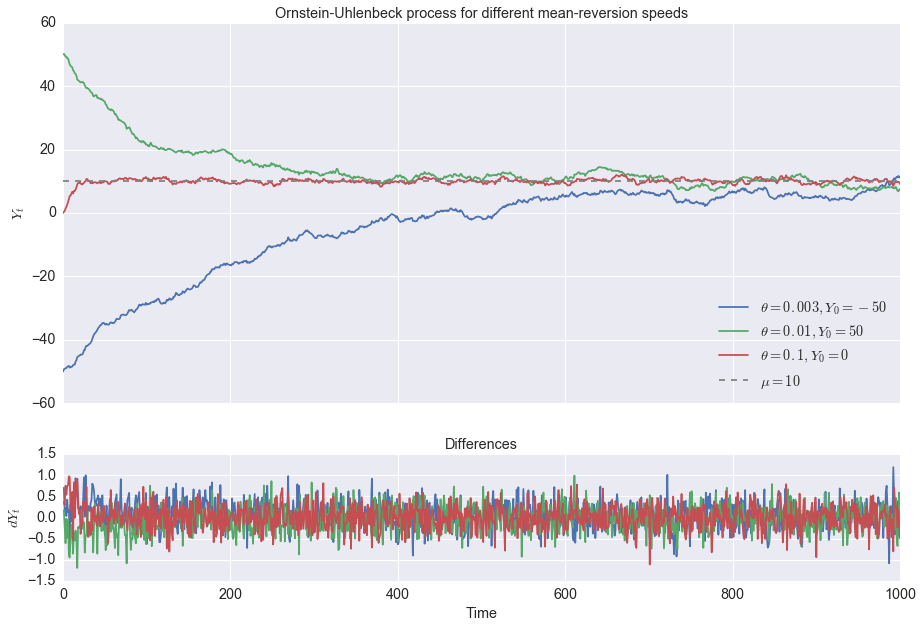

In [242]:
from matplotlib import gridspec

plt.figure(1, figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = plt.subplot(gs[0])
# plt.subplot(211)

# f, (a0, a1) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]})
# a0.plot(Y_t1)
# a0.plot(Y_t2)
# a0.plot(Y_t3)
# a0.axhline(mu, color='grey', linestyle='--') 
_ = Y_t1.plot()
_ = Y_t2.plot()
_ = Y_t3.plot()
_ = plt.axhline(mu, color='grey', linestyle='--') 

# _ = plt.ylabel('Series Value')
plt.title('Ornstein-Uhlenbeck process for different mean-reversion speeds')
plt.ylabel('$Y_t$')
plt.legend([r'$\theta={0}, Y_0={1:0.0f}$'.format(theta1, Y_t1[0]), 
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta2, Y_t2[0]),
            r'$\theta={0}, Y_0={1:0.0f}$'.format(theta3, Y_t3[0]),
            r'$\mu={0}$'.format(mu)],
           loc='lower right')

# # plt.subplot(212)
plt.subplot(gs[1], sharex=ax)
plt.title('Differences')
Y_t1.diff().plot()
Y_t2.diff().plot()
Y_t3.diff().plot()
plt.ylabel('$dY_t$')
plt.xlabel('Time')

## Tests

We require a more robust method to confirm statistically whether a series is stationary than just by intuition. Several tests exist, such as:

* Augmented-Dickey Fuller (ADF) test
* Hurst exponent
* Goodness of fit to Ornstein–Uhlenbeck process
* Kalman filters

Here we just cover the ADF test below.

### Augmented Dickey-Fuller (ADF)

The _Dickey-Fuller test_ tests the null hypothesis of whether a unit root is present in the autoregressive model of the time series (also known as AR(p) where _p_ is the lag order, see Appendix). 

For example, for AR(1):

$$
Y_t = \beta Y_{t-1} + \epsilon_t
$$

If $\beta=1$ the series has a 'unit root' and is hence non-stationary. The equation can be rewriten as:

$$
\Delta Y_t = (\beta - 1) Y_{t-1} + \epsilon_t = \phi Y_{t-1} + \epsilon_t
$$

where $\phi= \beta-1$. Hence, testing for unit root is equivalent to testing $\phi=0$. 

The value of the test statistic $\hat{\phi}/std.err(\hat{\phi})$ is then compared to the relevant critical values for the Dickey-Fuller distribution. If found lower, then the null hypothesis $\phi=0$ is rejected and the series can be considered stationary.

To 'augmented' version increases the significance of the test by including lag terms $\sum_k^p \phi_k \Delta Y_{t-k}$.  This however requires the estimation of the _optimal lag order p_. 

In addition, a _stability check_ can be done by ensuring the eigenvalues of the coefficients in the model lie within the 'unit circle' (see Appendix).

Other versions of the ADF test include drift and time-dependence terms, but these were not considered here - in practice the drift is often assumed zero  as it is usually smaller than any short-term fluctuations. Additional details on this topic can be found in [wiki ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), [wiki DF](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test), [wiki AR(p)](https://en.wikipedia.org/wiki/Autoregressive_model) and the Appendix.

### Python implementation

Clearly the above equations belong to the family of generalised linear models, which means the parameters can be estimated using the familiar linear regression  (see Appendix). 

The self-implementation of the ADF test, AR(p) model, stability checks and optimal lag selection can be found in the python script _analysis.py_. These were validated against the popular python [statsmodels](http://statsmodels.sourceforge.net/) library equivalents. 

#### Optimal Lag Selection

Choice of lag order can be a difficult problem. Standard approaches employ likelihood test or information criteria-based order selection. However, different methods can lead to different results. Also, keeping more lags can lead to  _model overfitting_. 

In practice, the choice of optimal lag is also evident from the Partial Autocorrelation Function (PACF) diagram: the significant serial autocorrelations will be above confidence limits.

Here we look at both the information criteria and the PACF to decide on the lag. 

Taking the simulated OU processes above and their differences, the lag is implied for each using the _Akaike Information Criterion_ (AIC) as defined for the ADF test in the Appendix (note this is different for AR(p)). The maximum lag order tried was as in statsmodels $12*(n/100)^{1/4}$ where $n$ is the number of observations. The results are summarised in the table below.


In [126]:
%run analysis.py

In [165]:
# GET OPTIMAL LAG for Y_T

ou_list = [Y_t1, Y_t2, Y_t3]
my_lag_list = []
sm_lag_list = []

for Y_t in ou_list:
    # Set maximum lag to iterate over 
    # (using default in statsmodels 12*(nobs/100)^{1/4}), from Greene referencing Schwert 1989)
    nobs = Y_t.shape[0]
    maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.)))
    print 'maxlag tried for {0} = {1}'.format(Y_t.name, maxlag)
    my_bestlag , my_icbest = get_optimal_lag(Y_t, maxlag=maxlag, model='adf')
    sm_result = adfuller(Y_t, maxlag=maxlag, regression='nc', autolag='AIC', regresults=True)
    my_lag_list += [(Y_t.name, my_bestlag, my_icbest)]
    
    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest    
    sm_lag_list += [(Y_t.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

maxlag tried for Y_t1 = 22
maxlag tried for Y_t2 = 22
maxlag tried for Y_t3 = 22
[('Y_t1', 1, 520.93374622812917), ('Y_t2', 12, 426.31405284313632), ('Y_t3', 20, 385.39391637942299)]
[('Y_t1', 1L, 509.67360033622003), ('Y_t2', 10L, 418.0354504764498), ('Y_t3', 6L, 367.81027381369745)]


In [195]:
# GET OPTIMAL LAG for dY_T (DIFFERENCES)

ou_list = [Y_t1, Y_t2, Y_t3]
my_lag_list = []
sm_lag_list = []

for Y_t in ou_list:
    # Set maximum lag to iterate over 
    # (using default in statsmodels 12*(nobs/100)^{1/4}), from Greene referencing Schwert 1989)
    nobs = Y_t.diff().dropna().shape[0]
    maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.)))
    print 'maxlag tried for {0} = {1}'.format(Y_t.name, maxlag)
    my_bestlag , my_icbest = get_optimal_lag(Y_t.diff().dropna(), maxlag=maxlag, model='adf')
    sm_result = adfuller(Y_t.diff().dropna(), maxlag=maxlag, regression='nc', autolag='AIC', regresults=True)
    my_lag_list += [('d'+Y_t.name, my_bestlag, my_icbest)]
    
    sm_bestlag = sm_result[3].usedlag
    sm_icbest = sm_result[3].icbest    
    sm_lag_list += [(Y_t.name, sm_bestlag, sm_icbest)]

print my_lag_list
print sm_lag_list

maxlag tried for Y_t1 = 22
maxlag tried for Y_t2 = 22
maxlag tried for Y_t3 = 22
[('dY_t1', 19, 540.52514917149801), ('dY_t2', 16, 439.18696233361766), ('dY_t3', 19, 383.41642842280908)]
[('Y_t1', 13L, 540.23497860920884), ('Y_t2', 11L, 432.05002604547667), ('Y_t3', 5L, 366.48450283464058)]


| OU  process | OU theta | Max lag tried | AIC optimal lag order | AIC value* |
|-------------|----------|-------------|---------------|------------|
| Y_t1        | 0.003    | 22          | 1             | 520.9337   |
| Y_t2        | 0.01     | 22          | 12            | 426.3140   |
| Y_t3        | 0.1      | 22          | 20            | 385.3939   |
| dY_t1       | 0.003    | 22          | 19            | 540.5251   |
| dY_t2       | 0.01     | 22          | 16            | 439.1869   |
| dY_t3       | 0.1      | 22          | 19            | 383.4164   |

Given that the optimal lag order comes out quite high for all, except for Y_t1, we instead use the empirical results from the PACF plot below, where it can be seen only the first lag is well above the 95% C.L. for all. For their differences, no lag order appears significant - although some higher order lags cross the C.L. band, it's only very slightly - this could be the reason why higher lags are detected using the AIC approach. 
With this, we therefore take the lag order to be $p=1$ for $Y_t$ and $p=0$ for $dY_t$.

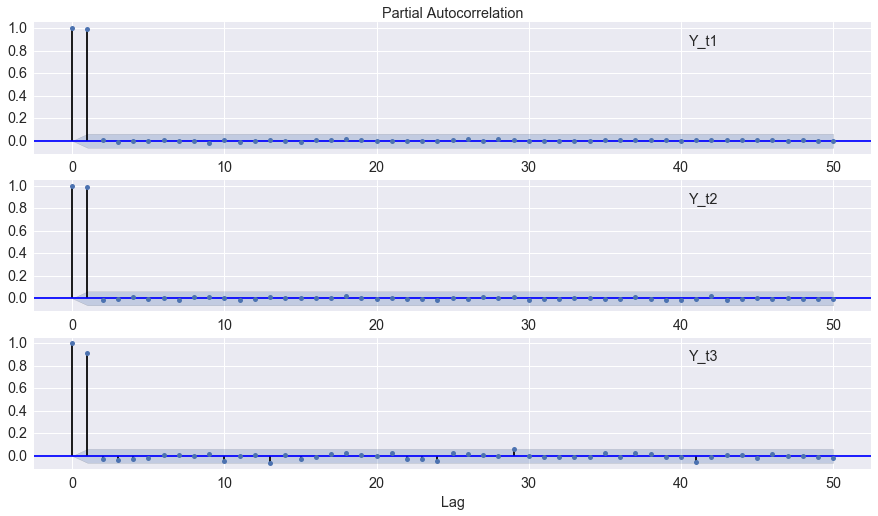

In [196]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(1, figsize=(15, 8))
gs = gridspec.GridSpec(3, 1)

for i, ou in enumerate(ou_list):       
    ax = plt.subplot(gs[i])
    fig = plot_pacf(ou, lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s=ou.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 2:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 2:
        plt.xlabel("Lag")

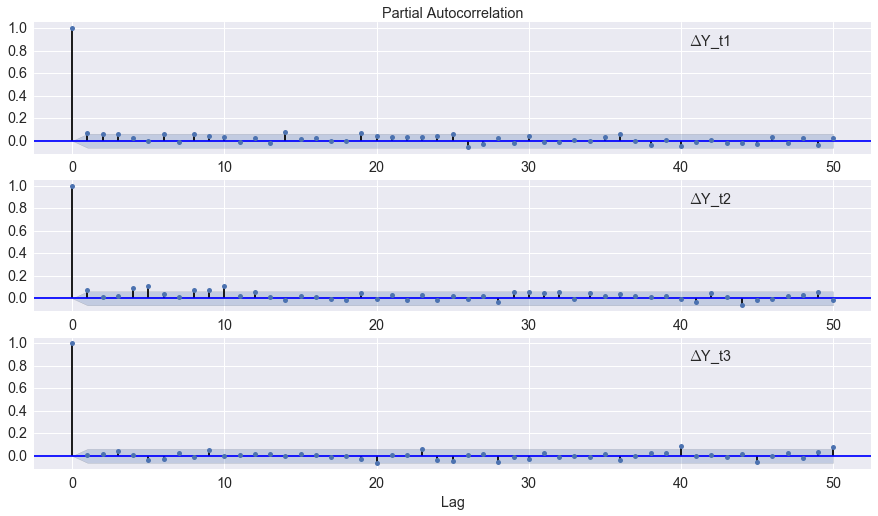

In [174]:
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(1, figsize=(15, 8))
gs = gridspec.GridSpec(3, 1)

for i, ou in enumerate(ou_list):       
    ax = plt.subplot(gs[i])
    fig = plot_pacf(ou.diff().dropna(), lags=50, alpha=0.05, ax=ax)
    plt.text(x=40.5, y=0.85, s="$\Delta$"+ou.name, size='x-large')
    if i > 0:
        plt.title("")
#     if i < 2:  # set ticks to invisible
#         plt.xticks([])
#     if i == 1:
#         plt.ylabel("Correlation")
    if i == 2:
        plt.xlabel("Lag")

#### ADF

We then apply the ADF test using the optimal lag from the PACF (see above) and compare the generated ADF statistic to the critical values to confirm or reject the stationary of the series. The results are summarised in the table below, with perhaps an unexpected result for Y_t3 - the OU process with the largest mean-reversion speed is non-stationary under the ADF test. For the rest is as expected. This highlights the need of carrying additional tests for stationarity instead of just relying on one?

In [243]:
my_result = {}  # result using my implementation
sm_result = {}  # statsmodels result

for i, ou in enumerate(ou_list):
    my_result[ou.name] = my_adfuller(ou, maxlag=1)
    sm_result[ou.name] = adfuller(x=ou, maxlag=1, regression='nc', autolag=None, regresults=True)
    # Also do it for the differences, note different lag used
    my_result['d' + ou.name] = my_adfuller(ou.diff().dropna(), maxlag=0)
    sm_result['d' + ou.name] = adfuller(x=ou.diff().dropna(), maxlag=0, regression='nc', autolag=None, regresults=True)

# Also do it for the random walk (brownian motion) process and its differences
my_result[Y_t.name] = my_adfuller(Y_t, maxlag=1)
sm_result[Y_t.name] = adfuller(x=Y_t, maxlag=1, regression='nc', autolag=None, regresults=True)
my_result['d' + Y_t.name] = my_adfuller(Y_t.diff().dropna(), maxlag=0)
sm_result['d' + Y_t.name] = adfuller(x=Y_t.diff().dropna(), maxlag=0, regression='nc', autolag=None, regresults=True)

# Print results
for key in my_result.keys():
    print "{0}: {1:.4f}".format(key, my_result[key]['adfstat'])
    print sm_result[key]
    print "pvalue=%0.4g" % sm_result[key][1]

Y_t: 2.3367
(2.3366955172953299, 0.99659059245712311, {'5%': -1.9412722092921209, '1%': -2.5679816723029334, '10%': -1.6165568281300424}, <statsmodels.tsa.stattools.ResultsStore object at 0x000000001081BA90>)
pvalue=0.9966
dY_t1: -28.5229
(-28.522897292518785, 0.0, {'5%': -1.9412722092921209, '1%': -2.5679816723029334, '10%': -1.6165568281300424}, <statsmodels.tsa.stattools.ResultsStore object at 0x00000000124A3470>)
pvalue=0
dY_t3: -31.3399
(-31.339850560382406, 0.0, {'5%': -1.9412722092921209, '1%': -2.5679816723029334, '10%': -1.6165568281300424}, <statsmodels.tsa.stattools.ResultsStore object at 0x00000000104C6400>)
pvalue=0
dY_t2: -28.8665
(-28.866495912458522, 0.0, {'5%': -1.9412722092921209, '1%': -2.5679816723029334, '10%': -1.6165568281300424}, <statsmodels.tsa.stattools.ResultsStore object at 0x0000000010BC9C88>)
pvalue=0
Y_t1: -7.3820
(-7.3819504908207856, 8.3577016506355659e-12, {'5%': -1.9412722092921209, '1%': -2.5679816723029334, '10%': -1.6165568281300424}, <statsmodels

| Process | Theta | Type | ADF t-stat | 5% Crit. Val. | p-value  | Stationary |
|---------|-------|------|------------|---------------|----------|------------|
| Y_t     | 0     | BM   | 2.3367     | -1.9412       | 0.9966   | No         |
| dY_t    | 0     | BM   | -31.6044   | -1.9412       | 0.0      | Yes        |
| Y_t1    | 0.003 | OU   | -7.3820    | -1.9412       | 8.36E-12 | Yes        |
| dY_t1   | 0.003 | OU   | -28.5229   | -1.9412       | 0.0      | Yes        |
| Y_t2    | 0.01  | OU   | -7.7494    | -1.9412       | 1.22E-12 | Yes        |
| dY_t2   | 0.01  | OU   | -28.8665   | -1.9412       | 0.0      | Yes        |
| Y_t3    | 0.1   | OU   | -0.0434    | -1.9412       | 0.6697   | No         |
| dY_t3   | 0.1   | OU   | -31.3399   | -1.9412       | 0.0      | Yes        |

#### Stability Check

Lastly, the stability check is done on the vector of coefficients of the AR(p) system in the ADF test (see Appendix for details) to ensure further the reliability of results. This was also implemented in _analysis.py_ and the results are displayed in the above table, where all the cases were found stable.

In [2]:
%run analysis.py

In [251]:
for key in my_result.keys():
#     print key, my_result[key]['roots'], sm_result[key][3].roots
    print "{0} passes stability check: {1}".format(key, is_stable(my_result[key]['roots']))

Y_t passes stability check: True
dY_t1 passes stability check: True
dY_t3 passes stability check: True
dY_t2 passes stability check: True
Y_t1 passes stability check: True
Y_t2 passes stability check: True
Y_t3 passes stability check: True
dY_t passes stability check: False


In [297]:
my_result['dY_t']['roots']

array([-0.99982381])

In [9]:
ar_res = AR(np.array(Y_t.diff().dropna())).fit(maxlag=1, trend='nc', method='cmle')
ar_res2 = my_AR(Y_t.diff().dropna(), maxlag=1)

In [10]:
print ar_res.roots
print ar_res2['roots']

print ar_res.params
print ar_res2['params']

[-5674.59344282]
[-5674.59344282]
[-0.00017622]
[-0.00017622]


In [11]:
adf_res = adfuller(x=Y_t.diff().dropna(), maxlag=0, regression='nc', autolag=None, regresults=True)
adf_res2 = my_adfuller(Y_t.diff().dropna(), maxlag=0)

In [12]:
print adf_res2['params']
print ar_res2['params'] -1.0
print ar_res2['params']
print adf_res2['params'] + 1.0

[-1.00017622]
[-1.00017622]
[-0.00017622]
[-0.00017622]


In [13]:
print adf_res[3].resols.params
print ar_res.params -1.0
print ar_res.params
print adf_res[3].resols.params + 1.0

[-1.00017622]
[-1.00017622]
[-0.00017622]
[-0.00017622]


In [15]:
np.r_[1.0, -adf_res[3].resols.params]

array([ 1.        ,  1.00017622])

In [14]:
eigenvalues = np.roots(np.r_[1.0, -adf_res[3].resols.params])  # prepend 1 to -ve of params array to get characteristic equation
roots = eigenvalues ** -1.  # these are used to test for stability in is_stable method
print eigenvalues
print roots
print np.abs(roots)

[-1.00017622]
[-0.99982381]
[ 0.99982381]


In [19]:
ar_res = AR(np.array(Y_t1)).fit(maxlag=1, trend='nc', method='cmle')
ar_res2 = my_AR(Y_t1, maxlag=1)

adf_res = adfuller(x=Y_t1, maxlag=0, regression='nc', autolag=None, regresults=True)
adf_res2 = my_adfuller(Y_t1, maxlag=0)

Proving equivalence of ADF system with AR(p) system - coefficients should be equivalent as in adf_params = ar_params - 1 and ar_params = adf_params + 1

In [18]:
print adf_res2['params']
print ar_res2['params'] -1.0
print ar_res2['params']
print adf_res2['params'] + 1.0

[-0.00528585]
[-0.00528585]
[ 0.99471415]
[ 0.99471415]
